In [82]:
import autoreload
from ray.tune.analysis import Analysis
import pandas as pd
import multiprocessing
from make_video import make_video, parser
from config import get_config_by_name
import ray
import shutil
from IPython.display import display, FileLink
from matplotlib import pyplot as plt
from analysis_helpers import get_videos, get_scores, concat_videos, VideosDownloader, get_df_from_logdir
import numpy as np
import pickle
import os, json, re
from tqdm import tqdm
import gym_compete_rllib
from ap_rllib.config import get_trainer, get_config_by_name
import seaborn as sns

In [3]:
# need ray for parallel evaluation
ray.shutdown()
ray.init(num_cpus=28, ignore_reinit_error=True, log_to_driver=False)

2020-11-12 17:20:49,760	INFO resource_spec.py:212 -- Starting Ray with 37.35 GiB memory available for workers and up to 18.69 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-11-12 17:20:50,015	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-11-12 17:20:50,262	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '128.32.175.9',
 'raylet_ip_address': '128.32.175.9',
 'redis_address': '128.32.175.9:6379',
 'object_store_address': '/tmp/ray/session_2020-11-12_17-20-49_757888_22587/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-12_17-20-49_757888_22587/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-11-12_17-20-49_757888_22587'}

In [4]:
# loading data
exp_name = "adversarial_tune_eval_sb"
config = "defense_eval_interactive_sb"
analysis = Analysis("/home/sergei/ray_results/" + exp_name)
df = analysis.dataframe(metric='policy_reward_mean/player_1', mode=None)

In [89]:
SCORE_STEPS = 1# 15
VIDEO_STEPS = 1# 15

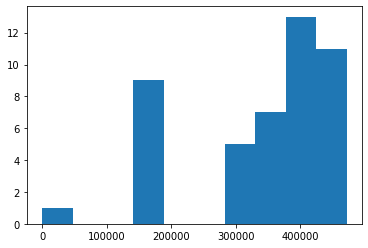

In [90]:
# removing short trials
plt.hist(df['episodes_total'])
df = df[df.episodes_total > 100000]

In [32]:
rdfs = {}
for i, trial in df.iterrows():
    rdfs[trial.trial_id] = get_df_from_logdir(trial.logdir)

100%|██████████| 2622/2622 [00:01<00:00, 1468.64it/s]


Trials ['2cfcb_00008', '2cfcb_00017']


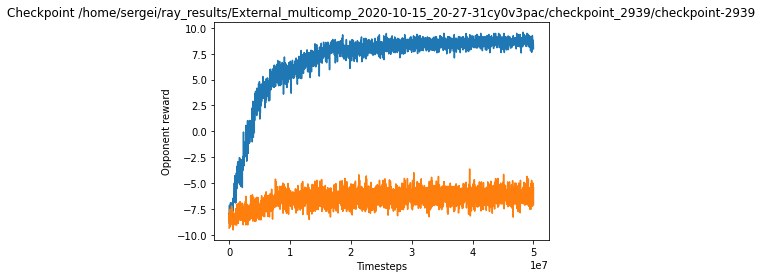

Trials ['2cfcb_00009', '2cfcb_00000']


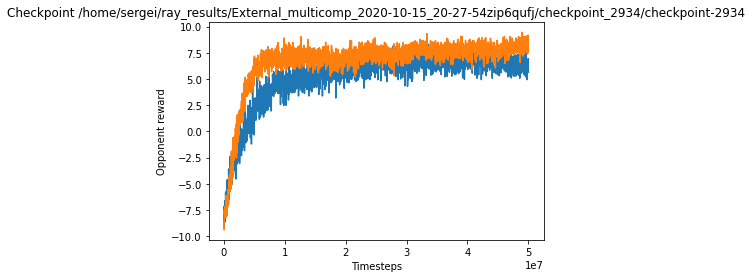

Trials ['2cfcb_00001', '2cfcb_00010']


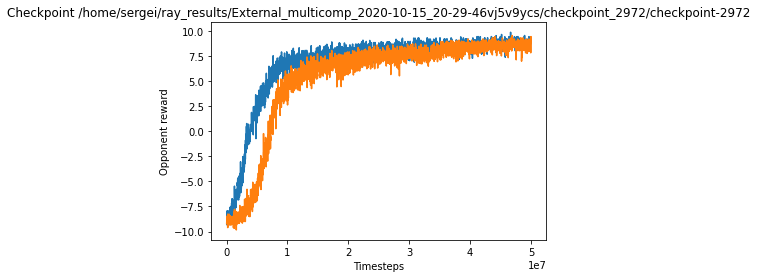

Trials ['2cfcb_00006', '2cfcb_00015']


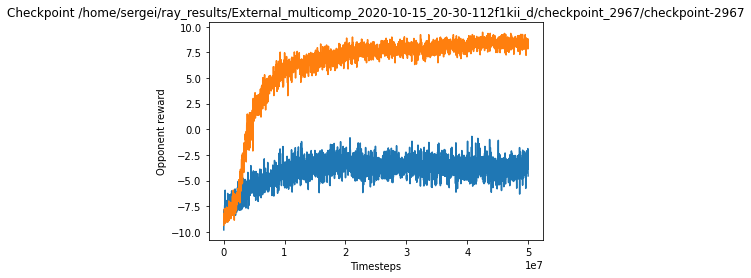

Trials ['2cfcb_00012', '2cfcb_00003']


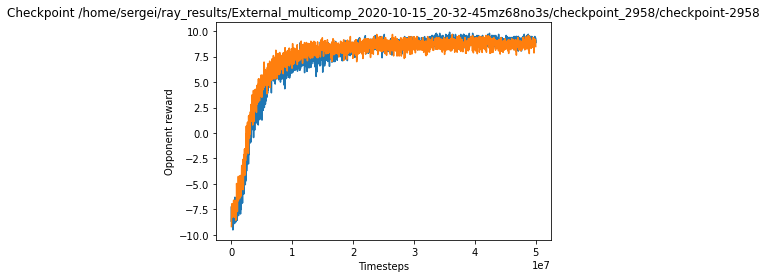

Trials ['2cfcb_00011', '2cfcb_00002']


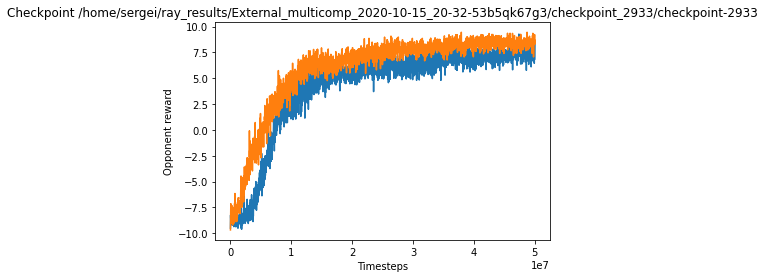

Trials ['2cfcb_00007', '2cfcb_00016']


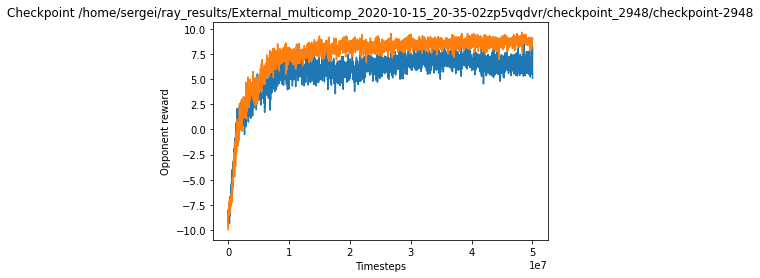

Trials ['2cfcb_00014', '2cfcb_00005']


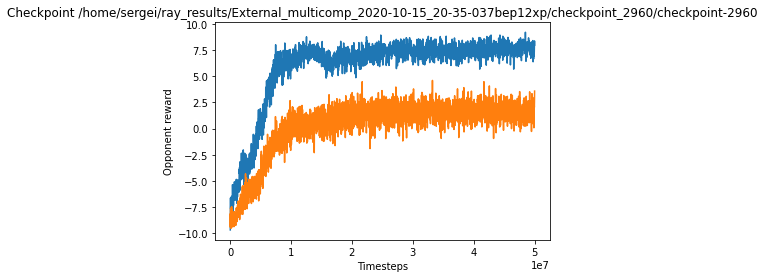

Trials ['2cfcb_00004', '2cfcb_00013']


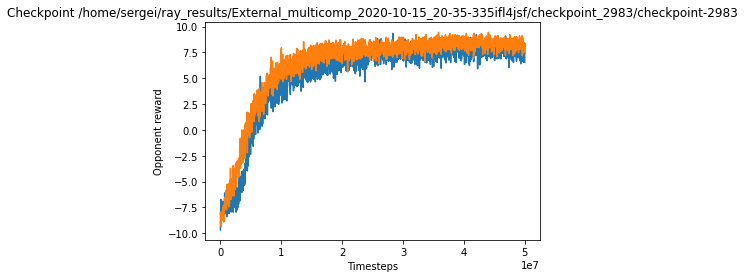

In [133]:
for _, df1 in df.groupby(['config/_checkpoint_restore']):
    plt.title(f"Checkpoint {df1.iloc[0]['config/_checkpoint_restore']}")
    plt.xlabel('Timesteps')
    plt.ylabel('Opponent reward')
    print("Trials", list(df1.trial_id))
    for trial in df1.trial_id:
        rdf = rdfs[trial]
        plt.plot(rdf['timesteps_total'], rdf['policy_reward_mean/player_1'])
    plt.show()

In [139]:
def fill_exponent_from_checkpoint_restore():
    """Add exponents field from the list of checkpoints."""
    exponents = []
    for _, row in df.iterrows():
        ckpt = row['config/_checkpoint_restore']
        params_path = os.path.join(os.path.split(os.path.split(ckpt)[0])[0], 'params.json')
        with open(params_path, 'r') as f:
            ckpt_config = json.loads(f.read())
        exponent = float(re.findall("'_burst_exponent': ([0-9\.]+)", ckpt_config['multiagent']['policy_mapping_fn'])[0])
        exponents.append(exponent)
    df['exponents'] = exponents

In [140]:
fill_exponent_from_checkpoint_restore()

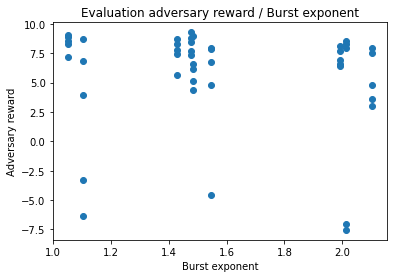

In [141]:
plt.title('Evaluation adversary reward / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary reward')
plt.scatter(df['exponents'], df['policy_reward_mean/player_1'])
plt.show()

In [ ]:
plt.title('Evaluation adversary reward / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary reward')
plt.scatter(df['exponents'], df['policy_reward_mean/player_1'])
plt.show()

In [114]:
config = 'external_test'

In [120]:
SCORE_STEPS = 15
VIDEO_STEPS = 3

In [121]:
scores = get_scores(df, steps=SCORE_STEPS, load_normal=False, config=config)
videos = get_videos(df, steps=VIDEO_STEPS, load_normal=False, config=config)

In [156]:
len(scores)

18

In [129]:
videos

['/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c708bf5e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c706094e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c709004a-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c74f794e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c75b9d96-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c7a3eb28-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-2

In [131]:
with VideosDownloader() as vd:

    for i, trial in tqdm(df.iterrows()):
        video = videos[i]
        vd.add_video(video, f"exponent_{round(trial['exponents'], 2)}_trial_{trial.trial_id}.mp4")

18it [00:00, 305.91it/s]


/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/videos.zip

In [126]:
df['score_adv'] = [x['wins_policy_player_1_reward'] for x in scores]

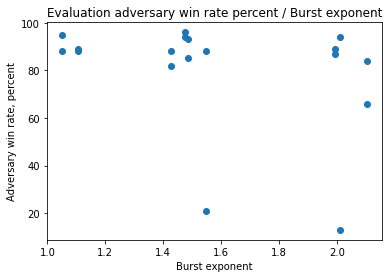

In [128]:
plt.title('Evaluation adversary win rate percent / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary win rate, percent')
plt.scatter(df['exponents'], df['score_adv'])
plt.show()

### Evaluating all policies against each other

In [96]:
config = 'external_test'
config_ = get_config_by_name(config)
config_['_verbose'] = False
config_['_policies'] = [None, 'pretrained', 'pretrained']
trainer_pretrained = get_trainer(config_)

Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Create

2020-11-12 17:40:52,795	WARNING util.py:37 -- Install gputil for GPU system monitoring.


Setting NN weights
Loading normalization
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


In [97]:
config = 'external_test'
config_ = get_config_by_name(config)
config_['_verbose'] = False
trainer = get_trainer(config_)

Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Create

2020-11-12 17:40:54,236	WARNING util.py:37 -- Install gputil for GPU system monitoring.


Setting NN weights
Loading normalization
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


In [70]:
policies = trainer.get_weights().keys()

In [91]:
weights = {p: [] for p in policies}

for _, row in df.iterrows():
    ckpt = row.checkpoint_rllib
    trainer.restore(ckpt)
    for p, w in trainer.get_weights().items():
        weights[p].append(w)

2020-11-12 17:35:30,799	INFO trainable.py:423 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-28_07-24-36d572h2g5/checkpoint_2633/checkpoint-2633
2020-11-12 17:35:30,800	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 2633, '_timesteps_total': None, '_time_total': 200047.52867126465, '_episodes_total': 472038}
2020-11-12 17:35:30,810	INFO trainable.py:423 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-30_02-08-11ia0_qn95/checkpoint_2609/checkpoint-2609
2020-11-12 17:35:30,811	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 2609, '_timesteps_total': None, '_time_total': 136909.22732496262, '_episodes_total': 376636}
2020-11-12 17:35:30,820	INFO trainable.py:423 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-30_01-59-458ag4aj78/checkpoint_2629/checkpoint-2629
2020-11-12 17:35:30,821	INFO trainabl

In [98]:
for p, w in trainer_pretrained.get_weights().items():
    weights[p].append(w)

In [99]:
def weights_equal(w1, w2):
    """List of weights == another list of weights?"""
    assert len(w1) == len(w2)
    for a, b in zip(w1, w2):
        if not np.allclose(a, b):
            return False
    return True

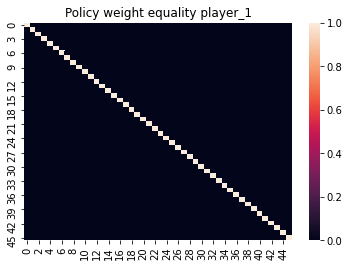

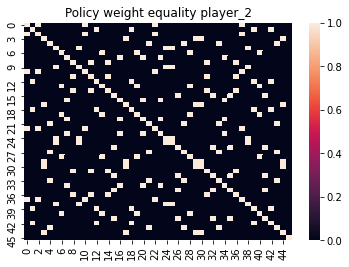

In [100]:
for p in policies:
    plt.title(f"Policy weight equality {p}")
    weq = [[weights_equal(x, y) for x in weights[p]] for y in weights[p]]
    sns.heatmap(weq)
    plt.show()

In [104]:
is_unique = {}
for p in policies:
    is_unique[p] = [not any([weights_equal(x, y) for j, y in enumerate(weights[p]) if j > i]) for i, x in enumerate(weights[p])]

In [106]:
print("Unique policies", {x: sum(y) for x, y in is_unique.items()})

Unique policies {'player_1': 46, 'player_2': 10}


In [114]:
print("Unique checkpoints restored", len(df['config/_checkpoint_restore'].unique()))

Unique checkpoints restored 9


In [130]:
import itertools
from uuid import uuid1

In [128]:
idxes = []

for w_pair in list(itertools.product(*[[(p, x) for x in range(len(w))] for p, w in weights.items()])):
    w_pair = dict(w_pair)
    valid_pair = True
    for p, idx in w_pair.items():
        if not is_unique[p][idx]:
            valid_pair = False
    if not valid_pair:
        continue
    
    idxes.append(w_pair)

In [140]:
for d in tqdm(idxes):
    trainer.set_weights({p: weights[p][d[p]] for p in policies})
    ckpt = trainer.save(f"/tmp/{uuid1()}")
    w_hash = sum([sum([np.sum(t) for t in y]) for y in trainer.get_weights().values()])
    d['checkpoint_rllib'] = ckpt
    d['hash'] = w_hash

100%|██████████| 460/460 [00:02<00:00, 199.87it/s]


In [143]:
hashes = [x['hash'] for x in idxes]

In [146]:
assert len(hashes) == len(set(hashes)), "Some pairs are the same"

In [151]:
fn = "/tmp/to_eval.csv"

In [476]:
df_to_eval = pd.DataFrame(idxes)
df_to_eval.to_csv(fn, index=False)

In [477]:
# run python -m ap_rllib_experiment_analysis.score_video_many --gin_config configs/score_make_video.gin --dataframe /tmp/to_eval.csv --score

In [478]:
with open(fn + "_scores.json", 'r') as f:
    eval_data = json.load(f)
if len(eval_data) < len(df_to_eval):
    print("Warning: not enough data", len(eval_data), len(df_to_eval))

In [479]:
for i, dta in enumerate(eval_data):
    for key, val in dta.items():
        if not key.endswith('reward'): continue
#         print(i, key, val)
        df_to_eval.loc[i, key] = val

In [480]:
df_to_eval

,player_1,player_2,checkpoint_rllib,hash,trials_episode_reward,wins_episode_reward,losses_episode_reward,ties_episode_reward,trials_policy_player_1_reward,wins_policy_player_1_reward,losses_policy_player_1_reward,ties_policy_player_1_reward,trials_policy_player_2_reward,wins_policy_player_2_reward,losses_policy_player_2_reward,ties_policy_player_2_reward
0,0,34,/tmp/a878baaa-2553-11eb-8c5f-e0d55e6af99c/chec...,4381.369831,100.0,12.0,88.0,0.0,100.0,92.0,8.0,0.0,100.0,8.0,92.0,0.0
1,0,36,/tmp/a878baab-2553-11eb-8c5f-e0d55e6af99c/chec...,4367.817321,100.0,10.0,90.0,0.0,100.0,94.0,6.0,0.0,100.0,6.0,94.0,0.0
2,0,37,/tmp/a878baac-2553-11eb-8c5f-e0d55e6af99c/chec...,4382.765925,100.0,16.0,84.0,0.0,100.0,88.0,12.0,0.0,100.0,12.0,88.0,0.0
3,0,38,/tmp/a878baad-2553-11eb-8c5f-e0d55e6af99c/chec...,4389.006600,100.0,11.0,89.0,0.0,100.0,95.0,5.0,0.0,100.0,5.0,95.0,0.0
4,0,40,/tmp/a878baae-2553-11eb-8c5f-e0d55e6af99c/chec...,4358.757821,100.0,11.0,89.0,0.0,100.0,91.0,9.0,0.0,100.0,9.0,91.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,45,41,/tmp/a96ebc1b-2553-11eb-8c5f-e0d55e6af99c/chec...,4450.147018,100.0,55.0,45.0,0.0,100.0,53.0,47.0,0.0,100.0,47.0,53.0,0.0
456,45,42,/tmp/a96ebc1c-2553-11eb-8c5f-e0d55e6af99c/chec...,4469.526201,100.0,63.0,37.0,0.0,100.0,44.0,56.0,0.0,100.0,56.0,44.0,0.0
457,45,43,/tmp/a96ebc1d-2553-11eb-8c5f-e0d55e6af99c/chec...,4434.196636,100.0,53.0,47.0,0.0,100.0,61.0,39.0,0.0,100.0,39.0,61.0,0.0
458,45,44,/tmp/a96ebc1e-2553-11eb-8c5f-e0d55e6af99c/chec...,4464.591859,100.0,43.0,57.0,0.0,100.0,59.0,41.0,0.0,100.0,41.0,59.0,0.0


In [512]:
df_pivot = pd.pivot_table(df_to_eval, values='wins_policy_player_1_reward', index=['player_1'],
                    columns=['player_2'], aggfunc=np.sum)

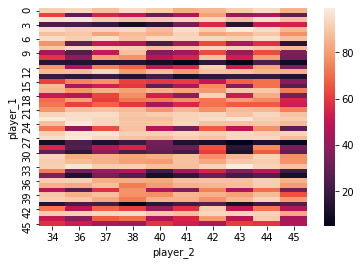

In [513]:
sns.heatmap(df_pivot)

In [514]:
df_pivot

player_2,34,36,37,38,40,41,42,43,44,45
player_1,,,,,,,,,,
0,92.0,94.0,88.0,95.0,91.0,84.0,86.0,91.0,95.0,85.0
1,62.0,28.0,55.0,51.0,30.0,46.0,81.0,40.0,46.0,28.0
2,97.0,97.0,91.0,89.0,90.0,93.0,94.0,87.0,96.0,88.0
3,24.0,23.0,19.0,10.0,16.0,33.0,56.0,15.0,52.0,54.0
4,95.0,92.0,93.0,94.0,87.0,96.0,91.0,98.0,95.0,86.0
5,88.0,90.0,82.0,87.0,85.0,93.0,82.0,85.0,90.0,78.0
6,95.0,92.0,96.0,89.0,94.0,94.0,94.0,92.0,96.0,88.0
7,78.0,29.0,51.0,47.0,23.0,43.0,64.0,44.0,58.0,15.0
8,90.0,94.0,93.0,92.0,87.0,90.0,94.0,92.0,90.0,86.0


In [548]:
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
import sklearn, scipy

In [583]:
df_pivot_norm = sklearn.preprocessing.normalize(df_pivot)

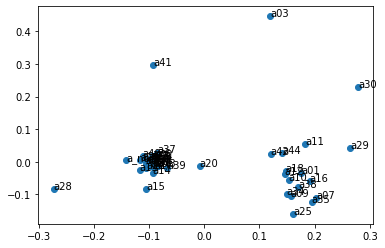

In [584]:
dr = PCA(2)
data = dr.fit_transform(df_pivot_norm)
plt.scatter(*data.T)
for adv in df_pivot.index:
    plt.text(*data[adv, :], s=adv_name(adv))

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.0466492838395296


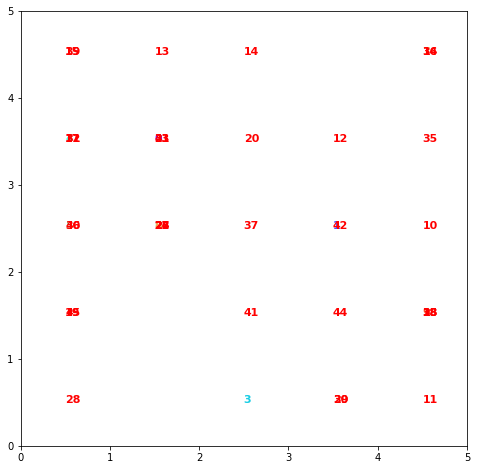

In [586]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import scale

# load the digits dataset from scikit-learn
data = np.array(df_pivot_norm)
data = scale(data)
num = df_pivot.index

som = MiniSom(5, 5, 10, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.pca_weights_init(data)
som.train(data, 5000, random_order=True, verbose=True)  # random training

plt.figure(figsize=(8, 8))
wmap = {}
im = 0
for x, t in zip(data, num):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()


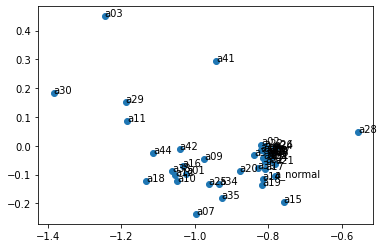

In [762]:
rp = SparseRandomProjection(n_components=2)
data = rp.fit_transform(df_pivot_norm)
plt.scatter(*data.T)
for adv in df_pivot.index:
    plt.text(*data[adv, :], s=adv_name(adv))

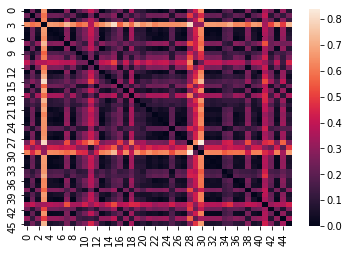

In [763]:
dist_pairs = scipy.spatial.distance.cdist(data, data)
sns.heatmap(dist_pairs)

(array([628., 302., 424., 328., 166., 100.,  42., 104.,  16.,   6.]),
 array([0.        , 0.08405545, 0.16811089, 0.25216634, 0.33622178,
        0.42027723, 0.50433268, 0.58838812, 0.67244357, 0.75649901,
        0.84055446]),
 <a list of 10 Patch objects>)

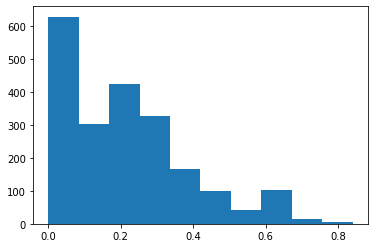

In [764]:
plt.hist(dist_pairs.flatten())

In [765]:
from sklearn.cluster import KMeans

In [766]:
random_states = np.random.randint(10000, size=10)
random_states

array([2128, 5499, 1945, 2396, 3201, 8057, 3366, 5885,  349, 4583])

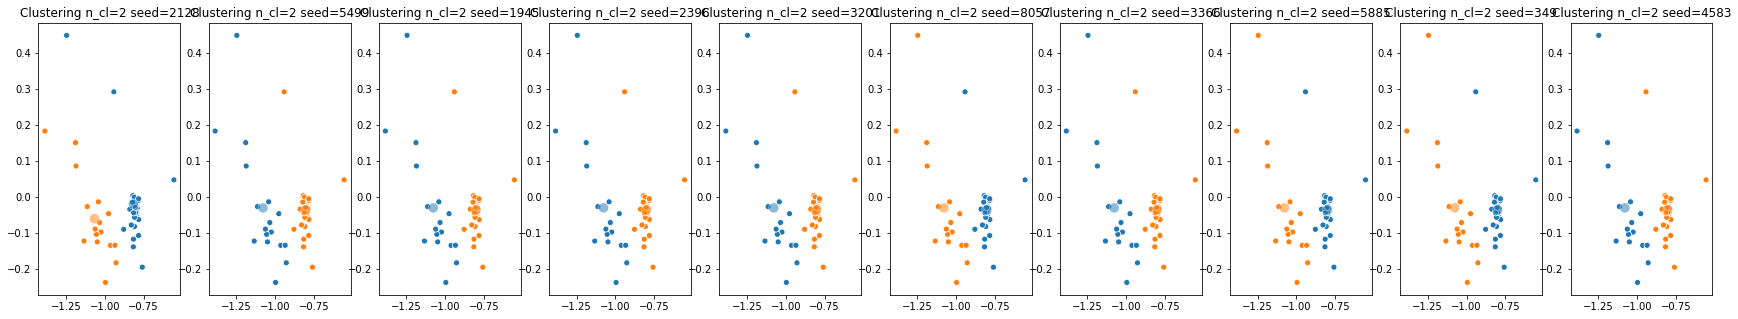

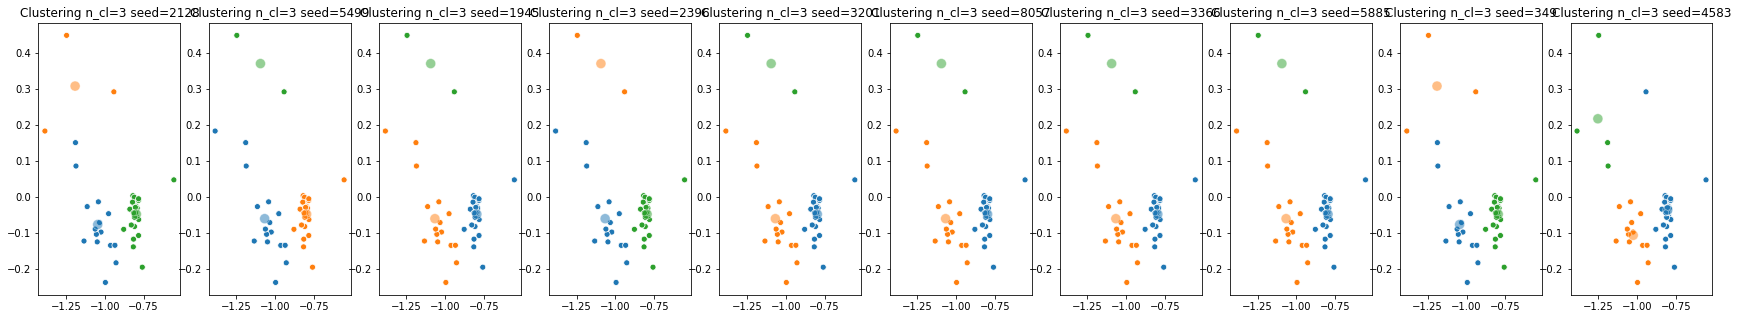

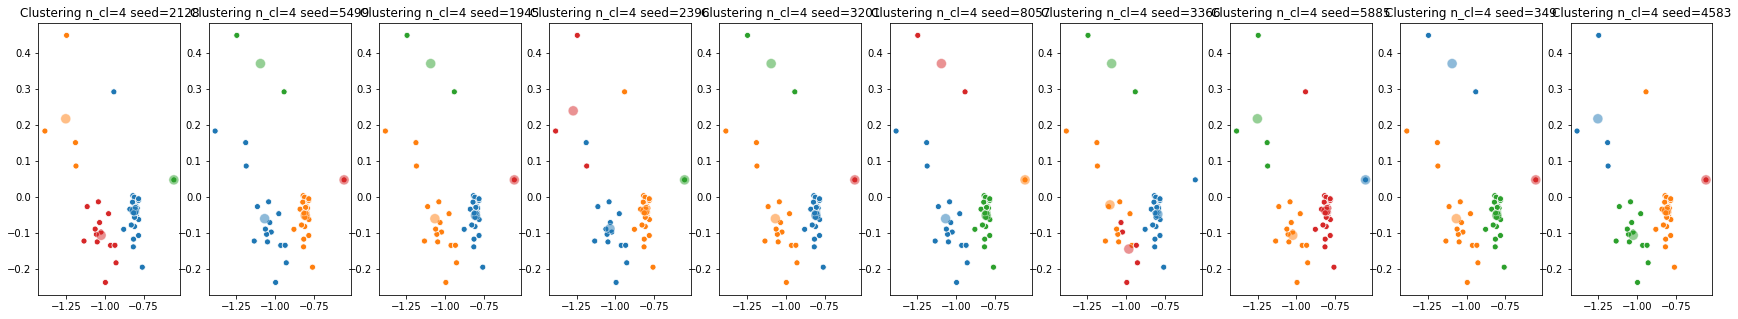

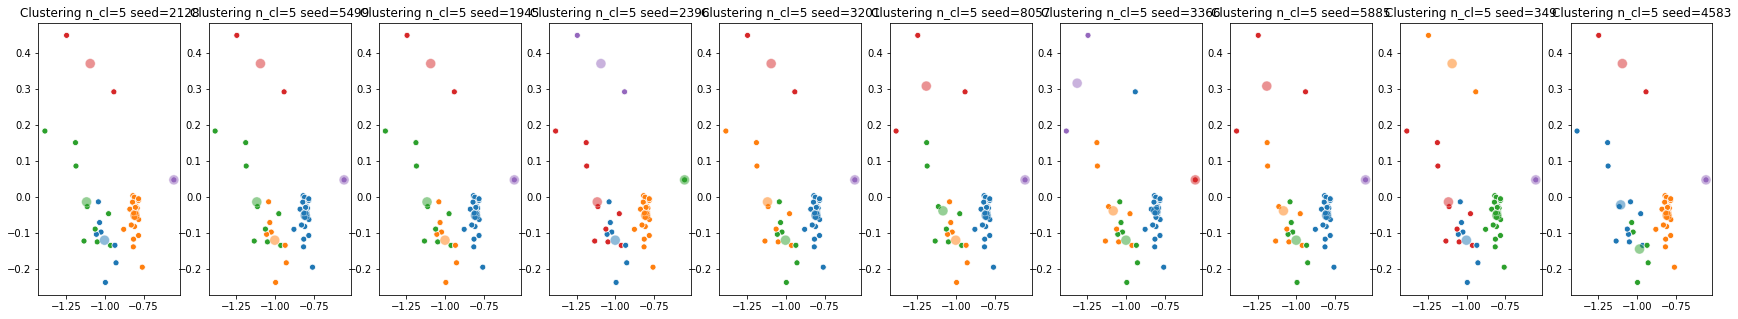

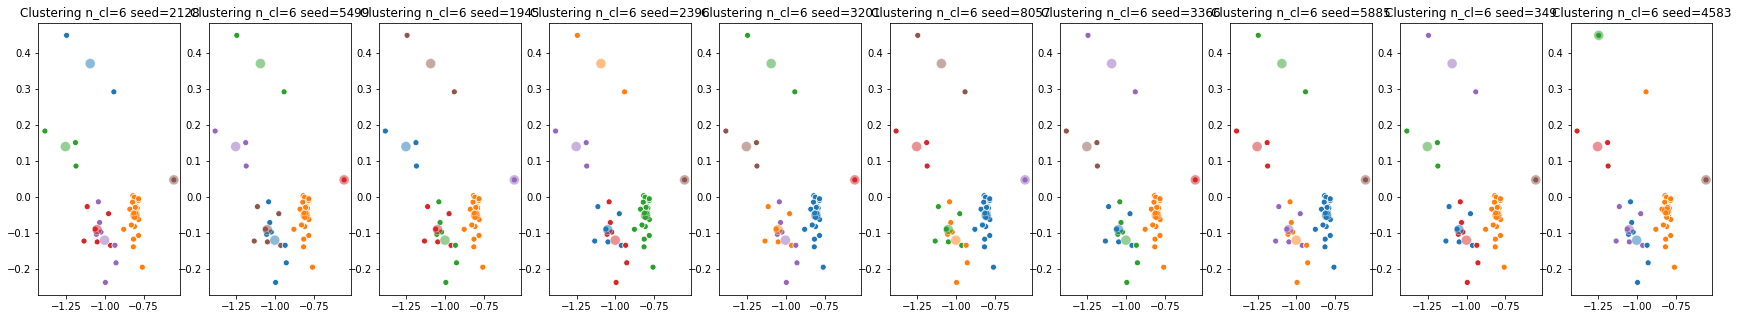

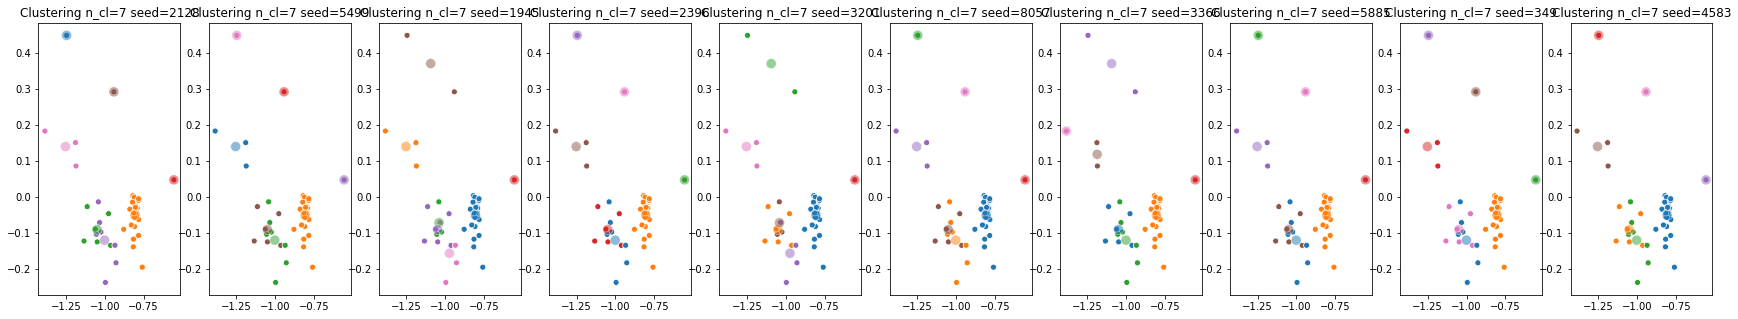

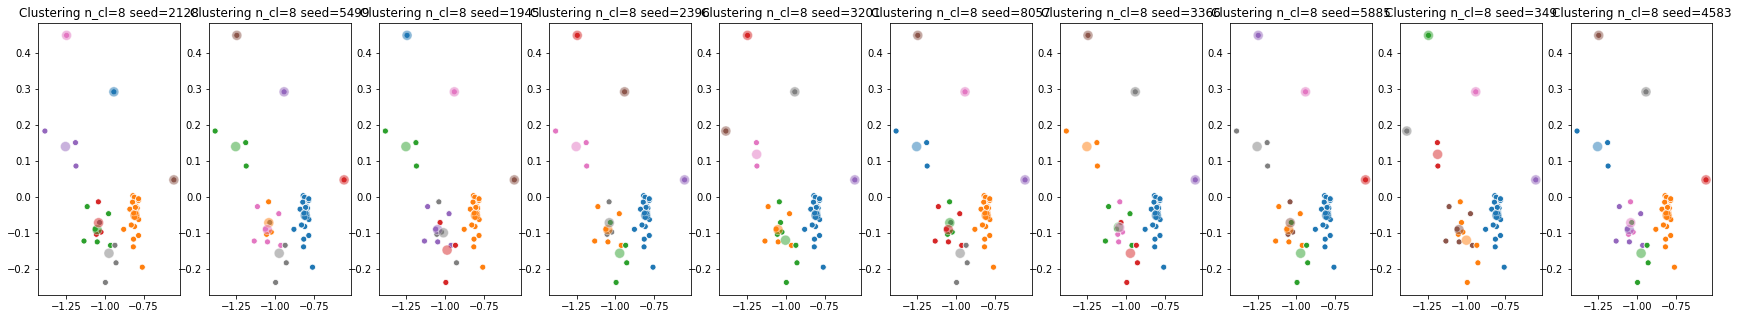

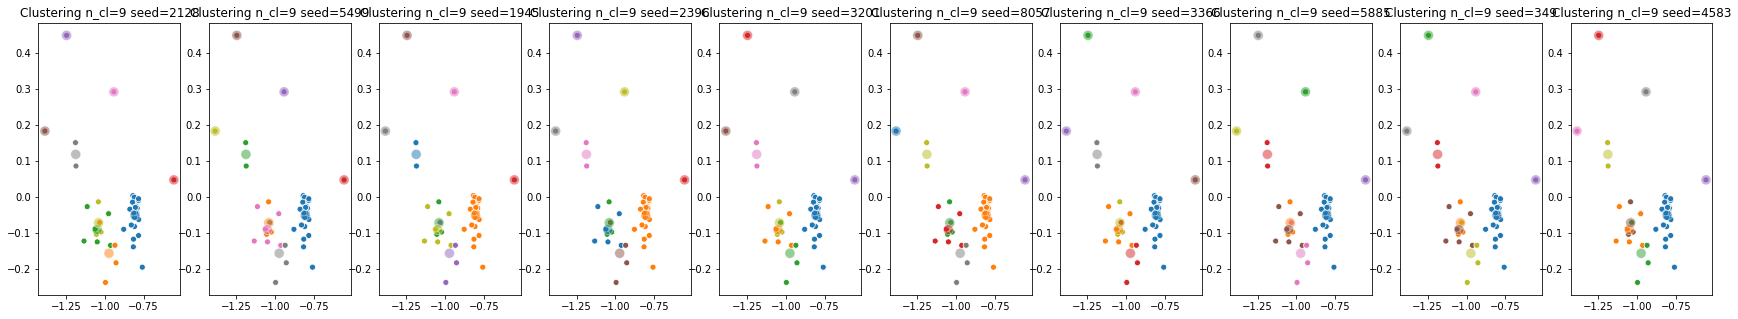

In [767]:
for n_clusters in range(2, 10):
    plt.figure(figsize=(30, 5))
    for i, random_state in enumerate(random_states):
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(df_pivot_norm)

        plt.subplot(1, len(random_states), i + 1)
        palette = sns.color_palette()[:n_clusters]
        plt.title(f"Clustering n_cl={n_clusters} seed={random_state}")
        sns.scatterplot(*data.T, hue=kmeans.labels_, palette=palette)
        sns.scatterplot(*rp.transform(kmeans.cluster_centers_).T, s=100, alpha=0.5, hue=np.arange(n_clusters), palette=palette)
        plt.gca().legend().remove()
    plt.show()

In [768]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(df_pivot_norm)

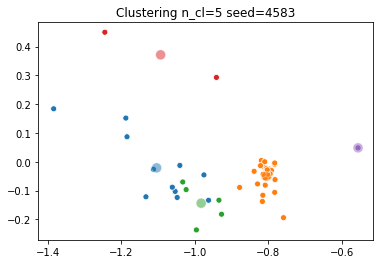

In [769]:
palette = sns.color_palette()[:n_clusters]
plt.title(f"Clustering n_cl={n_clusters} seed={random_state}")
sns.scatterplot(*data.T, hue=kmeans.labels_, palette=palette)
sns.scatterplot(*rp.transform(kmeans.cluster_centers_).T, s=100, alpha=0.5, hue=np.arange(n_clusters), palette=palette)
plt.gca().legend().remove()


In [770]:
def victim_name(idx):
    if isinstance(idx, str): return idx
    if idx == df_pivot.columns[-1]:
        return "v_normal"
    return "v%02d" % idx

def adv_name(idx):
    if isinstance(idx, str): return idx
    if idx == df_pivot.index[-1]:
        return "a_normal"
    return "a%02d" % idx

In [771]:
policies_1_to_cluster_center

array([0.16587067])

In [772]:
df_pivot_grouped = []

for cluster in range(n_clusters):
    policies_1 = np.where(kmeans.labels_ == cluster)[0]
    policies_1_norm = df_pivot_norm[kmeans.labels_ == cluster, :]
    policies_1_to_cluster_center = scipy.spatial.distance.cdist(policies_1_norm, kmeans.cluster_centers_[cluster:cluster+1, :])[0]
    policy_1_prototype = policies_1[np.argmin(policies_1_to_cluster_center)]
    print(cluster, policies_1)
    row = {}
    row['policies_1'] = ' '.join([adv_name(x) for x in policies_1])
    for i, policy_2 in enumerate(df_pivot.columns):
        row[policy_2] = df_pivot.loc[policy_1_prototype, policy_2]#np.median(df_pivot.loc[policies_1, policy_2])
    df_pivot_grouped.append(row)
print(df_pivot_grouped)
df_pivot_grouped = pd.DataFrame(df_pivot_grouped)
df_pivot_grouped = df_pivot_grouped.set_index('policies_1')

0 [ 9 10 11 12 18 25 29 30 38 42 44]
1 [ 0  2  4  5  6  8 13 14 15 17 19 20 21 22 23 24 26 27 31 32 33 36 37 39
 40 43 45]
2 [ 1  7 16 34 35]
3 [ 3 41]
4 [28]
[{'policies_1': 'a09 a10 a11 a12 a18 a25 a29 a30 a38 a42 a44', 34: 45.0, 36: 25.0, 37: 51.0, 38: 88.0, 40: 36.0, 41: 43.0, 42: 64.0, 43: 41.0, 44: 64.0, 45: 35.0}, {'policies_1': 'a00 a02 a04 a05 a06 a08 a13 a14 a15 a17 a19 a20 a21 a22 a23 a24 a26 a27 a31 a32 a33 a36 a37 a39 a40 a43 a_normal', 34: 92.0, 36: 94.0, 37: 88.0, 38: 95.0, 40: 91.0, 41: 84.0, 42: 86.0, 43: 91.0, 44: 95.0, 45: 85.0}, {'policies_1': 'a01 a07 a16 a34 a35', 34: 62.0, 36: 28.0, 37: 55.0, 38: 51.0, 40: 30.0, 41: 46.0, 42: 81.0, 43: 40.0, 44: 46.0, 45: 28.0}, {'policies_1': 'a03 a41', 34: 24.0, 36: 23.0, 37: 19.0, 38: 10.0, 40: 16.0, 41: 33.0, 42: 56.0, 43: 15.0, 44: 52.0, 45: 54.0}, {'policies_1': 'a28', 34: 10.0, 36: 24.0, 37: 12.0, 38: 19.0, 40: 32.0, 41: 13.0, 42: 11.0, 43: 5.0, 44: 12.0, 45: 7.0}]


Number of edges: 50 out of 50, sparsity 0.00%


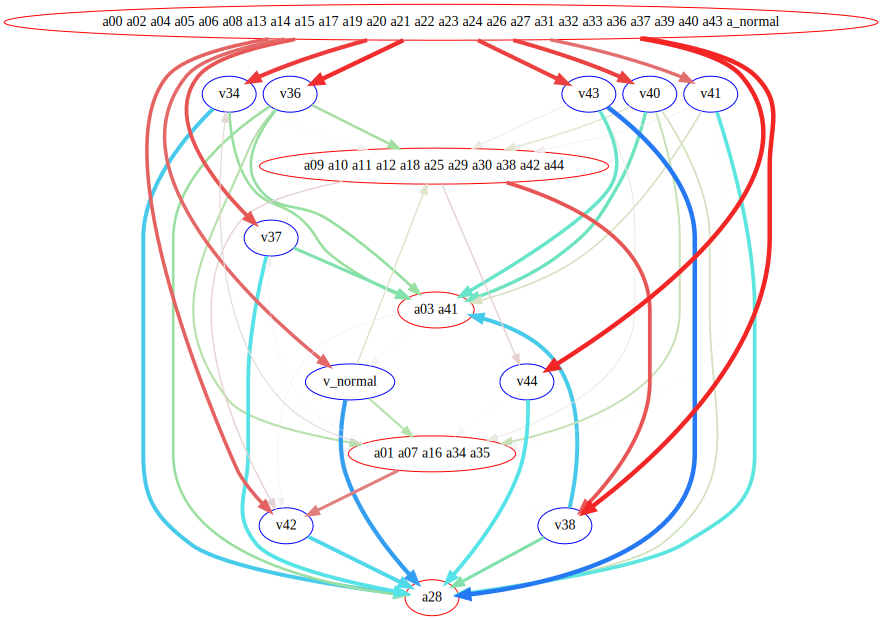

In [773]:
edges_lst = []
edge_strength = []
edge_color = []

# eng="circo"
# eng="neato"
eng=None
ps = Digraph(name='Win model', engine=eng, graph_attr=dict(nodesep="0.1"), node_attr={"nodesep": ".1", "overlap":"true"})
# node_attr={'shape': 'plaintext'})

for f in df_pivot_grouped.columns:
    ps.node(victim_name(f), color='blue')
for f in df_pivot_grouped.index:
    ps.node(adv_name(f), color='red')

# adding edges
edges = 0

for p2 in df_pivot_grouped.columns:
    for p1 in df_pivot_grouped.index:
        val = df_pivot_grouped.loc[p1, p2]
        
#         print(p1, p2)
        v1v2 = [adv_name(p1), victim_name(p2)]
        
        maxwidth = 5
        strength = abs(val - 50) / 50
        width = maxwidth * strength
        
        
        # val > 50 means that player 1 (adversary) wins
        # arrow goes FROM the winning player
        if val > 50:
            label = None#str(round(val))
            color = closest(strength, adv_win_color)
            ps.edge(*v1v2, label=label, penwidth=str(width), color=color, len=".1")
            edges_lst.append(v1v2)
            edge_strength.append(strength)
            edge_color.append(color)
            edges += 1
        else:
            label = None#str(round(val))
            color = closest(strength, vct_win_color)
            ps.edge(*v1v2[::-1], label=label, penwidth=str(width), color=color, len=".1")
            edge_strength.append(strength)
            edge_color.append(color)
            edges_lst.append(v1v2[::-1])
            edges += 1

max_edges = len(df_pivot_grouped.index) * len(df_pivot_grouped.columns)
percent = int(100 - 100. * edges / max_edges)
print("Number of edges: %d out of %d, sparsity %.2f%%" % \
      (edges, max_edges, percent))

# f_out = f"CausalModel"
# ps.render(filename=f_out, format='png')

ps

In [774]:

allnodes = [v for e in edges_lst for v in e]
import networkx as nx
import matplotlib.pyplot as plt

# Create Directed Graph
G=nx.DiGraph()

# Add a list of nodes:
G.add_nodes_from(allnodes)

# Add a list of edges:
G.add_edges_from(edges_lst)

def strength_for_cycle(cycle):
    strengths = []
#     cycle = cycle + [cycle[0]]
    for i in range(len(cycle) - 1):
        v1, v2 = cycle[i:i+2]
        e_idx = edges_lst.index([v1, v2])
        strength = edge_strength[e_idx]
        strengths.append(strength)
    return strengths

cycles = list(nx.simple_cycles(G))
cycles = [cycle + [cycle[0]] for cycle in cycles]
    
#Return a list of cycles described as a list o nodes
strengths = [strength_for_cycle(cycle) for cycle in cycles]
min_strength = [min(x) for x in strengths]

data = []
for idx in np.argsort(min_strength)[::-1]:
    data.append(dict(cycle=cycles[idx], edge_strength=strengths[idx], min_stength_percent=min_strength[idx] * 100))
pd.DataFrame(data)

,cycle,edge_strength,min_stength_percent
0,"[v_normal, a09 a10 a11 a12 a18 a25 a29 a30 a38...","[0.3, 0.76, 0.8, 0.08]",8.0
1,"[a01 a07 a16 a34 a35, v34, a09 a10 a11 a12 a18...","[0.24, 0.1, 0.76, 0.8, 0.08, 0.44]",8.0
2,"[a01 a07 a16 a34 a35, v34, a09 a10 a11 a12 a18...","[0.24, 0.1, 0.28, 0.08]",8.0
3,"[a01 a07 a16 a34 a35, v34, a03 a41, v_normal, ...","[0.24, 0.52, 0.08, 0.3, 0.28, 0.08]",8.0
4,"[a01 a07 a16 a34 a35, v34, a03 a41, v_normal, ...","[0.24, 0.52, 0.08, 0.44]",8.0
5,"[a01 a07 a16 a34 a35, v37, a03 a41, v_normal, ...","[0.1, 0.62, 0.08, 0.3, 0.28, 0.08]",8.0
6,"[a01 a07 a16 a34 a35, v37, a03 a41, v_normal, ...","[0.1, 0.62, 0.08, 0.44]",8.0
7,"[a01 a07 a16 a34 a35, v34, a09 a10 a11 a12 a18...","[0.24, 0.1, 0.76, 0.8, 0.04, 0.08]",4.0
8,"[a01 a07 a16 a34 a35, v34, a03 a41, v44, a01 a...","[0.24, 0.52, 0.04, 0.08]",4.0
9,"[a01 a07 a16 a34 a35, v37, a03 a41, v44, a01 a...","[0.1, 0.62, 0.04, 0.08]",4.0


In [515]:
from graphviz import Digraph

In [516]:
from colour import Color
n_colors = 100
adv_win_color = list(Color("white").range_to("red", n_colors))
vct_win_color = list(Color("white").range_to("blue", n_colors))

In [517]:
def closest(frac, colors):
    """Closest color to a fraction."""
    closest_idx = np.argmin(np.abs(np.linspace(0, 1, n_colors) - frac))
    return colors[closest_idx].get_hex_l()

Number of edges: 460 out of 460, sparsity 0.00%


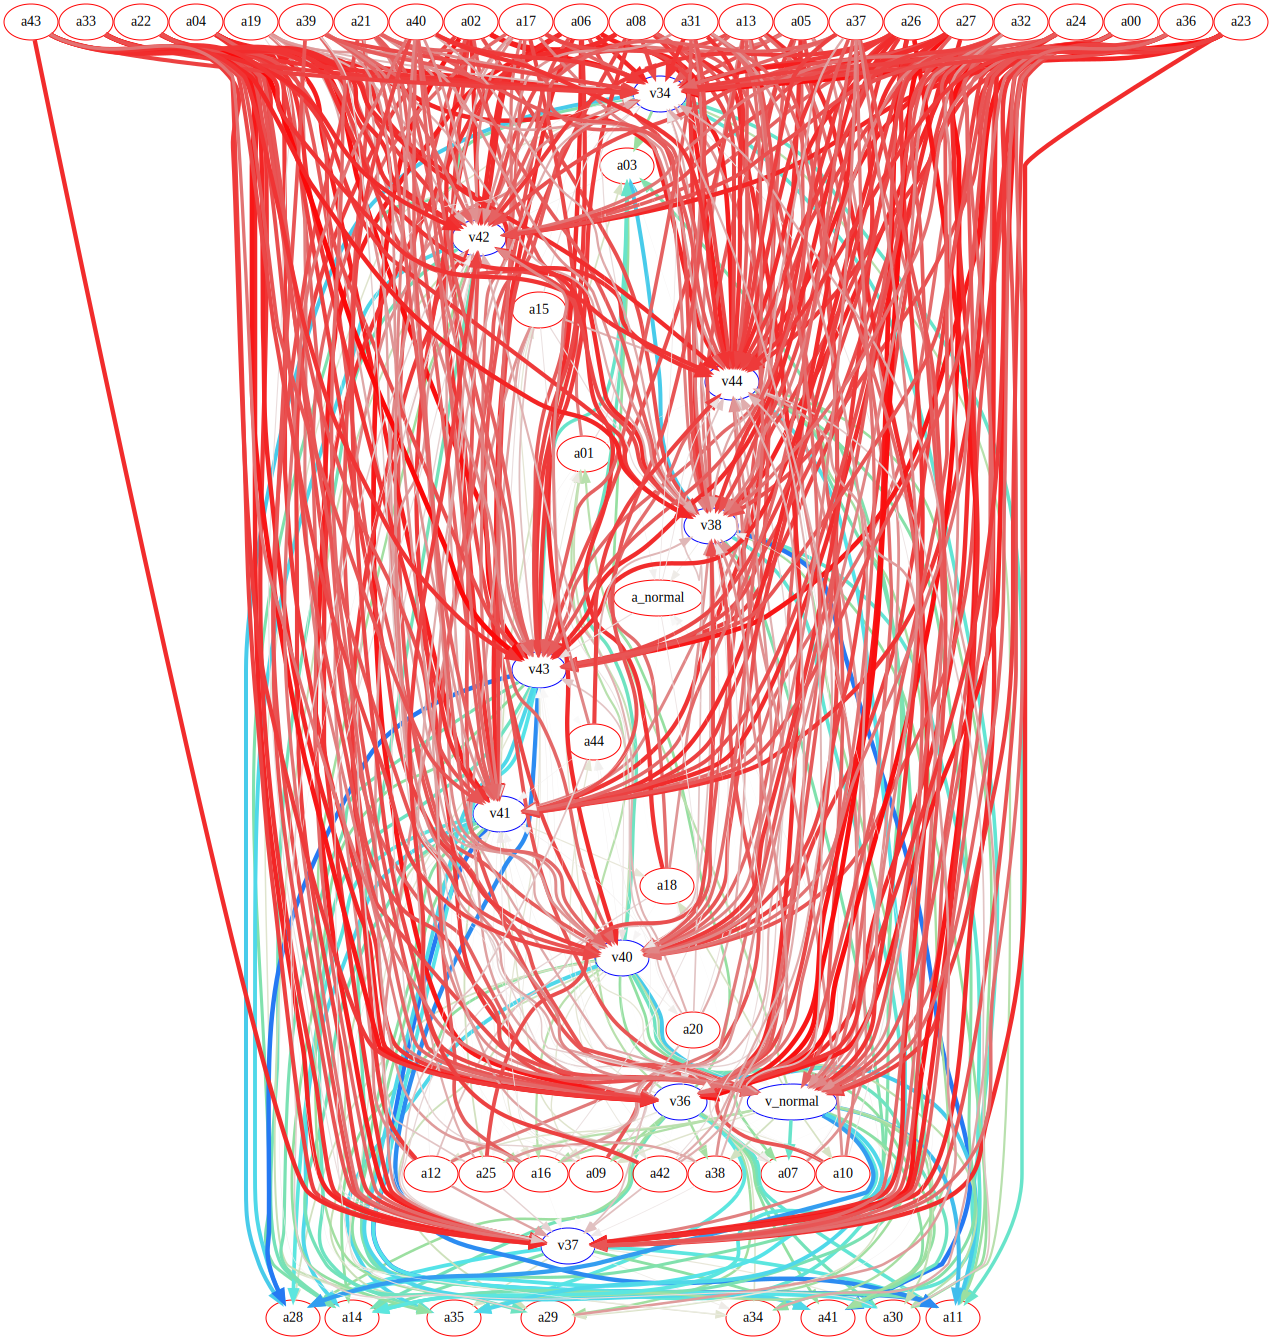

In [526]:
edges_lst = []
edge_strength = []
edge_color = []

# eng="circo"
# eng="neato"
eng=None
ps = Digraph(name='Win model', engine=eng, graph_attr=dict(nodesep="0.01"), node_attr={"nodesep": ".1", "overlap":"true"})
# node_attr={'shape': 'plaintext'})

assert df_pivot.columns.name == 'player_2' # victim
assert df_pivot.index.name == 'player_1' # adversary

for f in df_pivot.columns:
    ps.node(victim_name(f), color='blue')
for f in df_pivot.index:
    ps.node(adv_name(f), color='red')

# adding edges
edges = 0

for p2 in df_pivot.columns:
    for p1 in df_pivot.index:
        val = df_pivot.loc[p1, p2]
        
#         print(p1, p2)
        v1v2 = [adv_name(p1), victim_name(p2)]
        
        maxwidth = 5
        strength = abs(val - 50) / 50
        width = maxwidth * strength
        
        
        # val > 50 means that player 1 (adversary) wins
        # arrow goes FROM the winning player
        if val > 50:
            label = None#str(round(val))
            color = closest(strength, adv_win_color)
            ps.edge(*v1v2, label=label, penwidth=str(width), color=color, len=".001")
            edges_lst.append(v1v2)
            edge_strength.append(strength)
            edge_color.append(color)
            edges += 1
        else:
            label = None#str(round(val))
            color = closest(strength, vct_win_color)
            ps.edge(*v1v2[::-1], label=label, penwidth=str(width), color=color, len=".001")
            edge_strength.append(strength)
            edge_color.append(color)
            edges_lst.append(v1v2[::-1])
            edges += 1

max_edges = len(df_pivot.index) * len(df_pivot.columns)
percent = int(100 - 100. * edges / max_edges)
print("Number of edges: %d out of %d, sparsity %.2f%%" % \
      (edges, max_edges, percent))

# f_out = f"CausalModel"
# ps.render(filename=f_out, format='png')

ps

In [527]:
len(df_pivot.index) + len(df.columns)

149

In [531]:

allnodes = [v for e in edges_lst for v in e]
import networkx as nx
import matplotlib.pyplot as plt

# Create Directed Graph
G=nx.DiGraph()

# Add a list of nodes:
G.add_nodes_from(allnodes)

# Add a list of edges:
G.add_edges_from(edges_lst)

def strength_for_cycle(cycle):
    strengths = []
#     cycle = cycle + [cycle[0]]
    for i in range(len(cycle) - 1):
        v1, v2 = cycle[i:i+2]
        e_idx = edges_lst.index([v1, v2])
        strength = edge_strength[e_idx]
        strengths.append(strength)
    return strengths

cycles = list(nx.simple_cycles(G))
cycles = [cycle + [cycle[0]] for cycle in cycles]
    
#Return a list of cycles described as a list o nodes
strengths = [strength_for_cycle(cycle) for cycle in cycles]
min_strength = [min(x) for x in strengths]

data = []
for idx in np.argsort(min_strength)[::-1]:
    data.append(dict(cycle=cycles[idx], edge_strength=strengths[idx], min_stength=min_strength[idx]))
pd.DataFrame(data)

KeyboardInterrupt: 

In [474]:
edges_lst

[['a00', 'v34'],
 ['a01', 'v34'],
 ['a02', 'v34'],
 ['v34', 'a03'],
 ['a04', 'v34'],
 ['a05', 'v34'],
 ['a06', 'v34'],
 ['a07', 'v34'],
 ['a_normal', 'v34'],
 ['a00', 'v36'],
 ['v36', 'a01'],
 ['a02', 'v36'],
 ['v36', 'a03'],
 ['a04', 'v36'],
 ['a05', 'v36'],
 ['a06', 'v36'],
 ['v36', 'a07'],
 ['a_normal', 'v36'],
 ['a00', 'v37'],
 ['a01', 'v37'],
 ['a02', 'v37'],
 ['v37', 'a03'],
 ['a04', 'v37'],
 ['a05', 'v37'],
 ['a06', 'v37'],
 ['a07', 'v37'],
 ['a_normal', 'v37'],
 ['a00', 'v38'],
 ['a01', 'v38'],
 ['a02', 'v38'],
 ['v38', 'a03'],
 ['a04', 'v38'],
 ['a05', 'v38'],
 ['a06', 'v38'],
 ['a07', 'v38'],
 ['a_normal', 'v38'],
 ['a00', 'v40'],
 ['v40', 'a01'],
 ['a02', 'v40'],
 ['v40', 'a03'],
 ['a04', 'v40'],
 ['a05', 'v40'],
 ['a06', 'v40'],
 ['v40', 'a07'],
 ['a_normal', 'v40'],
 ['a00', 'v41'],
 ['a01', 'v41'],
 ['a02', 'v41'],
 ['a03', 'v41'],
 ['a04', 'v41'],
 ['a05', 'v41'],
 ['a06', 'v41'],
 ['a07', 'v41'],
 ['a_normal', 'v41'],
 ['a00', 'v42'],
 ['a01', 'v42'],
 ['a02', 'v42'],
 

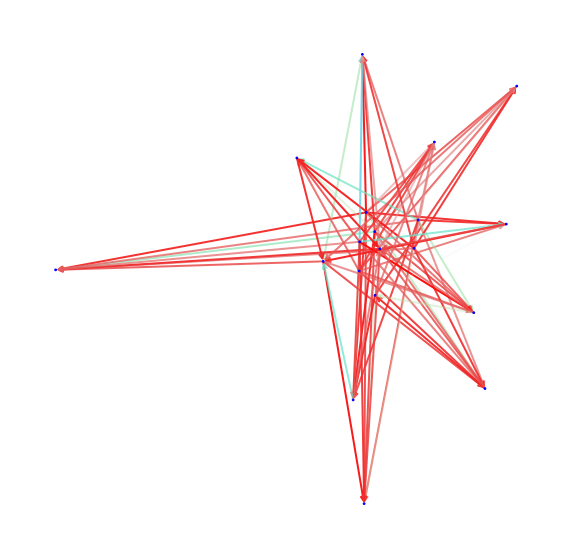

In [430]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.layout.spring_layout(G)

node_colors = 
node_sizes = [3 for i in range(len(G))]
M = G.number_of_edges()
edge_colors = edge_color
edge_alphas = (np.array(edge_strength) - np.min(edge_strength)) / (np.max(edge_strength) - np.min(edge_strength))#[(5 + i) / (M + 4) for i in range(M)]

plt.figure(figsize=(10, 10))


nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
# plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()


In [425]:
edge_strength

[4.2,
 1.2,
 4.699999999999999,
 2.6,
 4.5,
 3.8,
 4.5,
 2.8000000000000003,
 4.0,
 4.4,
 2.2,
 4.699999999999999,
 2.7,
 4.2,
 4.0,
 4.2,
 2.1,
 4.4,
 3.8,
 0.5,
 4.1,
 3.1,
 4.3,
 3.2,
 4.6000000000000005,
 0.1,
 4.3,
 4.5,
 0.1,
 3.9000000000000004,
 4.0,
 4.4,
 3.7,
 3.9000000000000004,
 0.3,
 4.2,
 4.1,
 2.0,
 4.0,
 3.4000000000000004,
 3.7,
 3.5,
 4.4,
 2.7,
 3.7,
 3.4000000000000004,
 0.4,
 4.3,
 1.7000000000000002,
 4.6000000000000005,
 4.3,
 4.4,
 0.7000000000000001,
 4.0,
 3.5999999999999996,
 3.1,
 4.4,
 0.6,
 4.1,
 3.2,
 4.4,
 1.4000000000000001,
 4.4,
 4.1,
 1.0,
 3.7,
 3.5,
 4.8,
 3.5,
 4.2,
 0.6,
 4.2,
 4.5,
 0.4,
 4.6000000000000005,
 0.2,
 4.5,
 4.0,
 4.6000000000000005,
 0.8,
 4.0,
 3.5,
 2.2,
 3.8,
 0.4,
 3.5999999999999996,
 2.8000000000000003,
 3.8,
 3.5,
 3.5999999999999996]